In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn import cross_validation, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pylab import rcParams
rcParams['figure.figsize'] = 15,3

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [104]:
def fit_clf(X_train, y_train):
    clf = XGBClassifier(booster='dart', max_depth=5, base_score=0.010)
    #cv = StratifiedKFold(y_train.iloc[:,0], n_folds=3, shuffle=True)
    cv = StratifiedKFold(y_train.iloc[:,0], n_folds=3)
    y_pred_train = np.ones(y_train.shape[0])
    for i, (train, test) in enumerate(cv):
        y_pred_train[test] = clf.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])[:,1]
        print("fold {}, ROC AUC: {:.3f}".format(i, metrics.roc_auc_score(y_train.iloc[test], y_pred_train[test])))
    print(metrics.roc_auc_score(y_train, y_pred_train))

#    clf.fit(X_train, y_train)
#    y_pred_train = clf.predict_proba(X_train)[:,1]
    plt.figure()
    thresholds = np.linspace(0.01, 1.00, 100)
    mcc = np.array([metrics.matthews_corrcoef(y_train, y_pred_train>thr) for thr in thresholds])
    plt.plot(thresholds, mcc)
    best_threshold = thresholds[mcc.argmax()]
    print("MCC: %f" % mcc.max())
    
    return clf, best_threshold


def predict(clf, X_train, y_train, best_threshold, X_test, y_test):
    train_predictions = clf.predict(X_train)
    train_predprob = (clf.predict_proba(X_train)[:,1] > best_threshold)
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, train_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, train_predprob))
    
    plt.figure()

    # Predict on testing data:
    test_predprob = (clf.predict_proba(X_test)[:,1] > best_threshold)
    #results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print('AUC Score (Test): %f' % metrics.roc_auc_score(y_test, test_predprob))
                
    feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return test_predprob.astype(int)


### nanかどうかだけで判断

### 特徴量を絞って全体で学習する

In [105]:
nrows = 50000
usecols_n = list(range(969))

X_train = pd.concat([
    pd.read_csv('../input/train_date.csv', index_col=0, nrows=nrows),
    pd.read_csv('../input/train_numeric.csv', index_col=0, nrows=nrows, usecols = usecols_n)
], axis=1)
y_train = pd.read_csv('../input/train_numeric.csv', index_col=0, nrows=nrows, usecols=[0,969])

X_train = X_train.isna()
y_train = (y_train == 1)

In [106]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X_train, y_train)

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.005, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [107]:
feat_indices = np.where(clf.feature_importances_>0.005)[0]

n_date_features = 1156
feat_indices_date = np.append([0], feat_indices[feat_indices < n_date_features] + 1)
feat_indices_numeric = np.append([0], feat_indices[feat_indices >= n_date_features] + 1 - n_date_features)


In [108]:
feat_indices.max()

1130

#### 全体で学習する

C:\Users\tmiya\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 0, ROC AUC: 0.657


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1, ROC AUC: 0.623


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 2, ROC AUC: 0.631
0.6348142406006663


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.158626


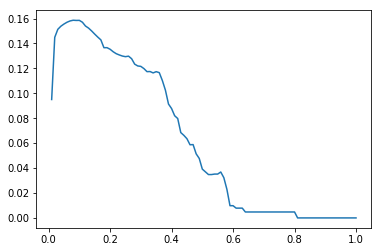

In [109]:
if n_date_features <= feat_indices.max():
    X_train = pd.concat([
        pd.read_csv('../input/train_date.csv', index_col=0, usecols=feat_indices_date),
        pd.read_csv('../input/train_numeric.csv', index_col=0, usecols=feat_indices_numeric)
    ], axis=1)
else:
    X_train = pd.read_csv('../input/train_date.csv', index_col=0, usecols=feat_indices_date)

y_train = pd.read_csv('../input/train_numeric.csv', index_col=0, usecols=[0,969])

X_train = X_train.isna()

clf, best_threshold = fit_clf(X_train, y_train)


### テスト

In [96]:
if n_date_features <= feat_indices.max():
    X_test = pd.concat([
        pd.read_csv('../input/test_date.csv', index_col=0, usecols=feat_indices_date),
        pd.read_csv('../input/test_numeric.csv', index_col=0, usecols=feat_indices_numeric)
    ], axis=1)
else:
    X_test = pd.read_csv('../input/test_date.csv', index_col=0, usecols=feat_indices_date)

X_test = X_test.isna()

preds = (clf.predict_proba(X_test)[:,1] > best_threshold).astype(np.int8)
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")


C:\Users\tmiya\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
